# FINAL PROJECT


Ryan Timbrook (RTIMBROO)<br>
DATE: 12/3/2019<br>
Topic: <br>


## 1. Objective
_____________________________________________________________________________________________
Task 1:

-	Build a unigram MNB model and a unigram SVMs model.
-	Print the top 10 indicative words for the most positive category and the most negative category from the MNB and SVMs models respectively. 
-	You can change other parameters to your preference. Report your choice and explain why. 
-	Report the confusion matrix, precisions, and recalls. Explain whether your models performed equally well on all categories, or some categories turn out to be easier or more difficult for MNB or SVMs. 
-	Submit your revised script along with your report.

Task 2:

Revise the script to build a MNB model and a SVMs model based on both unigram and bigram. For fair comparison, please keep the same 60% for training and the rest 40% for testing. 

- Compare the confusion matrix and other evaluation measures (accuracy, precision, recall). Discuss whether adding bi-grams was helpful for sentiment classification, based on MNB and SVMs respectively.

Task 3:

Revise the script to build the best model by tuning parameters and using the entire training data set (changing from 60% to 100%). Report what parameters you used to train the model, and its cross validation accuracy.


___________________________________________________________________________________________
## FOR RUNNING IN GOOGLE COLAB ONLY ##

In [1]:
# toggle for working with colab
isColab = False

In [2]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [3]:
# import packages for analysis and modeling
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import os
import io
from os import path
import re
from itertools import product
from datetime import date
from datetime import time
from datetime import datetime

# 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import itemfreq

import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
# get loggers
warnings.filterwarnings('ignore')

In [4]:
# custome python packages
import rtimbroo_utils_hw7 as br             # custome python helper functions

In [5]:
# get current date
now = datetime.utcnow().isoformat()
collection_date = re.findall('^[0-9]{4}-[0-9]{2}-[0-9]{2}',now)
collection_date

['2019-12-07']

In [6]:
# set global properties
notebook_file_name = 'classification_modeling_mnb_svm'
report_file_name = 'classification_modeling_mnb_svm'
app_name = 'classification_modeling_mnb_svm'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [7]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [8]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name+'_'+collection_date[0],level=log_level)

#### Create Model with CV
Python Package: [SciKit-Learn model_selection cross_validate](https://scikit-learn.org/stable/modules/cross_validation.html)   
See also [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more details.  

A risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.  

Cross-Validate at 10 folds...

In [9]:
# summary report containers
model_types = []
categories = []
vectorizers = []
ngrams = []
exp_model_names = []
dataset_versions = []
cross_folds = []
prediction_accuracys = []
total_prediction_points = []
test_recall_score_avgs = []
test_precision_score_avgs = []
train_recall_score_avgs = []
train_precision_score_avgs = []
total_build_times = []
total_predict_time = []
confusion_matrixs = []

In [10]:
def build_test_validate_models(vectorizer,mtype,model,m_name,X,y,reportPath,outputDir,cv=10,test_size=0.3,n_classes=2):
    model_names = []
    labels = [l for l in range(0,n_classes)]
    
    #------------------SUMMARY REPORT DATA ----------------------------#
    cross_folds.append(cv) # summary report
    exp_model_names.append(m_name) # summary report
    
    # get model type
    if mtype == 'mnb':
        model_types.append('Multinomial_Naive_Bayes')
    elif mtype == 'svm':
        model_types.append('LinearSVM')
    else:
        model_types.append('UNKNOWN')
    
    # get category
    category = ''
    if 'task1' in m_name:
        categories.append('task_1')
        category = 'task_1'
    elif 'task2' in m_name:
        categories.append('task_2')
        category = 'task_2'
    elif 'task3' in m_name:
        categories.append('task_3')
        category = 'task_3'
    elif 'task4' in m_name:
        categories.append('task_4')
        category = 'task_4'
    else:
        categories.append('UNKNOWN')
    
    # get vectorizer type
    v_type = ''
    if 'cnt' in m_name:
        vectorizers.append('count')
        v_type = 'count'
    elif 'tfidf' in m_name:
        vectorizers.append('tfidf')
        v_type = 'tfidf'
    else:
        vectorizers.append('UNKNOW')
    
    # get ngram type
    ngram_type = ''
    if 'unigram' in m_name:
        ngrams.append('unigram')
        ngram_type = 'unigram'
    elif 'bigram' in m_name:
        ngrams.append('bigram')
        ngram_type = 'bigram'
    else:
        ngrams.append('UNKNOWN')
    
    # get dataset version
    dataset_versions.append(f'v{m_name[-1:]}')
    d_version=m_name[-1:]
    
    
    #------------------------------------------------------------------------#
    
    
    # create training test splits
    # hold out part of the available data as a test set X_test, y_test
    with open(f'{reportPath}', 'a') as f:
        logger.info(f'Model Name:             {m_name}')
        f.write('{0:-<40} {1}\n'.format('Model Name:',m_name))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        # plot training validating label split
        br.plot_train_test_label_split(y_train, y_test, n_classes)
        
        # one hot encoding for dataset labels
        lbe = LabelEncoder()
        y_train = lbe.fit_transform(y_train)
        y_test = lbe.fit_transform(y_test)
        
        
        #-------------------Perform Vectorization of dataset----------------------------#
        train_vec = br.train_vector(logger, vectorizer, X_train, category=category, v_type=v_type, version=d_version)
        X_train_vec = train_vec[1]
        logger.info(f'X_train_vec.shape: {X_train_vec.shape}')
        
        # use the vocabulary constructed from the training data to vectorize the test data. 
        # Therefore, use "transform" only, not "fit_transform", 
        # otherwise "fit" would generate a new vocabulary from the test data
        X_test_vec = vectorizer.transform(X_test)
        logger.info(f'X_test_vec.shape: {X_test_vec.shape}')
        
        #-------------------Build Cross Validate Model----------------------------#
        
        scoring = ['precision_macro', 'recall_macro']
        t = 0.0
        with br.elapsed_timer() as elapsed:
            model_scores = cross_validate(model, X_train_vec, y_train, scoring=scoring, cv=cv, 
                                        return_train_score=True, return_estimator=True) 
            t = elapsed()
            logger.info(f' Build Time: [{t}]')
            f.write('{0:-<40} {1}\n'.format('Build Time: ',[t]))
            total_build_times.append(round(t, 4))
        
        #--------------------------------------------------------------------------#
        
        logger.debug(f'Fit Time:               {model_scores["fit_time"]} | Fit Time Avg: {np.mean(model_scores["fit_time"])}')
        logger.debug(f'Score Time:             {model_scores["score_time"]} | Score Time Avg: {np.mean(model_scores["score_time"])}')
        logger.debug(f'Test Recall Scores:     {model_scores["test_recall_macro"]} | Test Recall Avg: {np.mean(model_scores["test_recall_macro"])}')
        logger.debug(f'Test Precision Scores:  {model_scores["test_precision_macro"]} | Test Precision Avg: {np.mean(model_scores["test_precision_macro"])}')
        logger.debug(f'Train Recall Scores:    {model_scores["train_recall_macro"]} | Train Recall Avg: {np.mean(model_scores["train_recall_macro"])}')
        logger.debug(f'Train Precision Scores: {model_scores["train_precision_macro"]} | Train Precision Avg: {np.mean(model_scores["train_precision_macro"])}')
                    
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Fit Time:',[model_scores["fit_time"]],[np.mean(model_scores["fit_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Score Time:',[model_scores["score_time"]],[np.mean(model_scores["score_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Recall Scores:',[model_scores["test_recall_macro"]],[np.mean(model_scores["test_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Precision Scores:',[model_scores["test_precision_macro"]],[np.mean(model_scores["test_precision_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Recall Scores:',[model_scores["train_recall_macro"]],[np.mean(model_scores["train_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Precision Scores:',[model_scores["train_precision_macro"]],[np.mean(model_scores["train_precision_macro"])]))
        
        # update report value
        test_recall_score_avgs.append(round(np.mean(model_scores["test_recall_macro"]),4)) # summary report 
        test_precision_score_avgs.append(round(np.mean(model_scores["test_precision_macro"]),4)) # summary report 
        train_recall_score_avgs.append(round(np.mean(model_scores["train_recall_macro"]),4)) # summary report 
        train_precision_score_avgs.append(round(np.mean(model_scores["train_precision_macro"]),4))  # summary report            
                     
                     
        #---------------------BEST FIT ESTIMATOR-----------------------------------#
        # best fit estimator
        bestFit = model_scores["test_precision_macro"].argmax()
        model_scores_est = model_scores['estimator'][bestFit]
        logger.info(f'bestFit model: test_precision_macro.argmax(): {bestFit}')
        
                     
        #---------------------PRINT Top 10 Positive Words-----------------------------------#
        # Top 10 positive
        logger.info(f'Top and Bottom 10 POSITIVE Words Learned:')
        top_bottom_most_pos = br.show_most_and_least_informative_features(logger, vectorizer, model_scores_est, class_idx=2)           
        f.write('\n Top and Bottome 10 of Most POSITIVE Learned Words ')
        f.write('\n')
        for p in top_bottom_most_pos:
            f.write(f'{p}\n')
        f.write('\n')           
                     
        #---------------------PRINT Top 10 Negative Words-----------------------------------#
        # Top 10 negative
        logger.info(f'Top and Bottom 10 NEGATIVE Words Learned:')
        top_bottom_most_neg = br.show_most_and_least_informative_features(logger, vectorizer, model_scores_est, class_idx=0)
        f.write('\n Top and Bottome 10 of Most NEGATIVE Learned Words ')
        f.write('\n')
        for n in top_bottom_most_neg:
            f.write(f'{n}\n')
        f.write('\n')           
                     
        # predict on unseen data
        t = 0.0
        logger.info(f'Predict: X_test_vec.shape:{X_test_vec.shape}')
        with br.elapsed_timer() as elapsed:
            model_pred = model_scores_est.predict(X_test_vec)
            
            t = elapsed()
            logger.info(f'{m_name} with CV Predict Time: [{t}]')
            f.write('\n{0:-<40} {1}\n'.format('Predict Time:',[t]))
            
            total_predict_time.append(round(t,4)) # summary report
        #---------------------------------------------------------------------------#
        
        #---------------------EVALUATE MODEL----------------------------------------#
        misLabeled = (y_test != model_pred).sum()/X_test.shape[0]
        nbCVAccuractelyLabeled = 1-misLabeled

        logger.debug(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != model_pred).sum()}]')
        logger.debug(f'Percent Mislabeled: [{((y_test != model_pred).sum()/X_test.shape[0])}]')
        logger.debug(f'Percent Accurately Labeled: [{nbCVAccuractelyLabeled}]')
        f.write('\n')
        f.write('{0:-<40} {1} | {2}\n'.format('Total Number of points | Misslabeled Points:',[X_test.shape[0]],[(y_test != model_pred).sum()]))
        f.write('{0:-<40} {1}\n'.format('Percent Mislabeled:',[((y_test != model_pred).sum()/X_test.shape[0])]))
        f.write('{0:-<40} {1}\n'.format('Percent Accurately Labeled:',[nbCVAccuractelyLabeled]))
        
        prediction_accuracys.append(round(nbCVAccuractelyLabeled*100,2)) # summary report
        total_prediction_points.append(X_test.shape[0]) # summary report            
        
        # confusion matrix evaluation
        cm = confusion_matrix(y_test,model_pred, labels=labels)
        logger.info(f'{cm}')
        f.write(f'Confusion Matrix: \n{cm}\n')
        f.write(f'\n')
        
        confusion_matrixs.append(str(cm)) # summary report
        br.plot_confusion_matrix(cm,classes=labels)
        
        logger.info(f'y_test head: {y_test[:10]}')
        logger.info(f'model_pred head: {model_pred[:10]}')
    
        # classification report
        target_names = [class_to_description[l] for l in labels]
        cr = classification_report(y_test, model_pred, target_names=target_names)
        logger.info(f'{cr}')
        f.write(f'Classification Report: \n{cr}\n')
        f.write(f'\n')
                     
        #             
        
        #---------------------------------------------------------------------------#
                    
        #--------------------Model Results-------------------------------------------#
        result_df = pd.DataFrame()
        result_df['True_Label'] = y_test
        result_df['Predicted_Label'] = model_pred
        result_df['Phrase'] = X_test[1]
                     
        return result_df
        
        # create a merged dataframe of the true, predicted labels along with the word frequency vector for observation
        #fname = feature_vec_file.split('.')
        #fversion = fname[0][-1:]
                     
        #path = f'{outputDir}/v{fversion}/{feature_vec_file}'
        #save_as = f'{outputDir}/{mtype}_{m_name}_predicted_results.csv'

        #predicted_results_wf = br.evaluate_predicted_result(logger, f'{path}',result_df)
        #logger.info(predicted_results_wf.head(10))

        #predicted_results_wf.to_csv(save_as,index=False)

## 2. OBTAIN the data   
________________________________________________________________________________________________


The dataset is comprised of 

* **train.tsv:** 

**The sentiment labels are:**<br>

* 0 - negative
* 1 - neutral
* 2 - positive


In [11]:
n_classes = 3
class_to_label = {0:'0',1:'1',2:'2'}
label_to_class = {'0':0, '1':1, '2':2,}
label_to_description = {'0':'negative', '1':'neutral', '2':'positive'}
class_to_description = {0:'negative', 1:'neutral', 2:'positive'}

In [12]:
# datasets file names to load
#train = pd.read_csv(f'{dataDir}/train/train_tweets_combined_master_clean.csv', encoding='latin')

# best data set of NFL labeled data to be used for modeling
#train = pd.read_csv(f'{dataDir}/train/sentiment_labeled_train_nfl_clean.csv', encoding='latin')
train = pd.read_csv(f'{dataDir}/train/nfl_master_sent_merged_timeseries.csv', encoding='latin')


# data set that has airline and gop tweet data - poor modeling performance 
#train = pd.read_csv(f'{dataDir}/train/train_tweets_master.csv', encoding='latin')



logger.info(f'train shape: {train.shape}')
logger.info(f'train size: {train.size}')
logger.info(f'train len: {len(train)}')
logger.info(f'train info: {train.info()}')

train shape: (9928, 17)
train size: 168776
train len: 9928
train info: None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9928 entries, 0 to 9927
Data columns (total 17 columns):
id                  9928 non-null int64
created_at          9928 non-null object
date                9928 non-null object
time                9928 non-null object
user                9928 non-null object
favorite_count      9928 non-null float64
year                9928 non-null int64
month               9928 non-null int64
day_of_month        9928 non-null int64
day_of_week         9928 non-null int64
nfl_type            9928 non-null object
nfl_schedule_wk     9928 non-null int64
text                9870 non-null object
text_clean          9761 non-null object
sentiment_scores    9928 non-null object
sentiment           9928 non-null object
sentiment_class     9928 non-null int64
dtypes: float64(1), int64(7), object(9)
memory usage: 1.3+ MB


In [13]:
train.head()

,id,created_at,date,time,user,favorite_count,year,month,day_of_month,day_of_week,nfl_type,nfl_schedule_wk,text,text_clean,sentiment_scores,sentiment,sentiment_class
0,1200925257407827968,Sat Nov 30 23:51:08 +0000 2019,2019-11-30,23:51:08,JT_Evans97,28503.0,2019,11,30,5,player,13,You mean the same fan experts who could see La...,mean fan experts could see lamar jackson would...,"{'neg': 0.0, 'neu': 0.522, 'pos': 0.478, 'comp...",positive,2
1,1200924548700495872,Sat Nov 30 23:48:19 +0000 2019,2019-11-30,23:48:19,MigiziLaFern,161.0,2019,11,30,5,player,13,Deshaun Watson or Sam Darnold? WhoShouldIStart,sam darnold whoshouldistart,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1
2,1200922963375280129,Sat Nov 30 23:42:01 +0000 2019,2019-11-30,23:42:01,TifdanyBrooks,10198.0,2019,11,30,5,player,13,RT Top 5 current NFL quarterbacks 1. Tom Bra...,top current quarterbacks tom brady lamar jacks...,"{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",positive,2
3,1200922228168237057,Sat Nov 30 23:39:05 +0000 2019,2019-11-30,23:39:05,Schlarb23,1376.0,2019,11,30,5,player,13,A NFL team I love: Browns A NFL team I like: P...,team love browns team like panthers team disli...,"{'neg': 0.3, 'neu': 0.381, 'pos': 0.319, 'comp...",positive,2
4,1200922016636948481,Sat Nov 30 23:38:15 +0000 2019,2019-11-30,23:38:15,JoeZo88,85828.0,2019,11,30,5,player,13,Deshaun Watson,NaN,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",neutral,1


In [14]:
# - Util function to convert labels
def convert_sent_labels(df,col):
    sentiment_classes = []
    for sent in df[col]:
        if sent == 'negative':
            sentiment_classes.append('0')
        elif sent == 'neutral':
            sentiment_classes.append('1')
        elif sent == 'positive':
            sentiment_classes.append('2')
        else:
            sentiment_classes.append('-1')
            logger.warning(f'***WARNING****: missing sentiment label: {sent}')
    return sentiment_classes

In [15]:
#train['sentiment_class'] = convert_sent_labels(train,'sentiment')

In [16]:
train.head()

,id,created_at,date,time,user,favorite_count,year,month,day_of_month,day_of_week,nfl_type,nfl_schedule_wk,text,text_clean,sentiment_scores,sentiment,sentiment_class
0,1200925257407827968,Sat Nov 30 23:51:08 +0000 2019,2019-11-30,23:51:08,JT_Evans97,28503.0,2019,11,30,5,player,13,You mean the same fan experts who could see La...,mean fan experts could see lamar jackson would...,"{'neg': 0.0, 'neu': 0.522, 'pos': 0.478, 'comp...",positive,2
1,1200924548700495872,Sat Nov 30 23:48:19 +0000 2019,2019-11-30,23:48:19,MigiziLaFern,161.0,2019,11,30,5,player,13,Deshaun Watson or Sam Darnold? WhoShouldIStart,sam darnold whoshouldistart,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1
2,1200922963375280129,Sat Nov 30 23:42:01 +0000 2019,2019-11-30,23:42:01,TifdanyBrooks,10198.0,2019,11,30,5,player,13,RT Top 5 current NFL quarterbacks 1. Tom Bra...,top current quarterbacks tom brady lamar jacks...,"{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",positive,2
3,1200922228168237057,Sat Nov 30 23:39:05 +0000 2019,2019-11-30,23:39:05,Schlarb23,1376.0,2019,11,30,5,player,13,A NFL team I love: Browns A NFL team I like: P...,team love browns team like panthers team disli...,"{'neg': 0.3, 'neu': 0.381, 'pos': 0.319, 'comp...",positive,2
4,1200922016636948481,Sat Nov 30 23:38:15 +0000 2019,2019-11-30,23:38:15,JoeZo88,85828.0,2019,11,30,5,player,13,Deshaun Watson,NaN,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",neutral,1


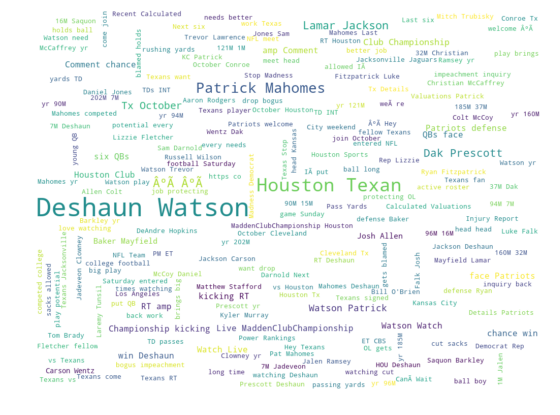

In [17]:
# wordcloud of complete training set - uncleaned text
br.wordcloud_draw(train['text'], color='white',max_words=200)

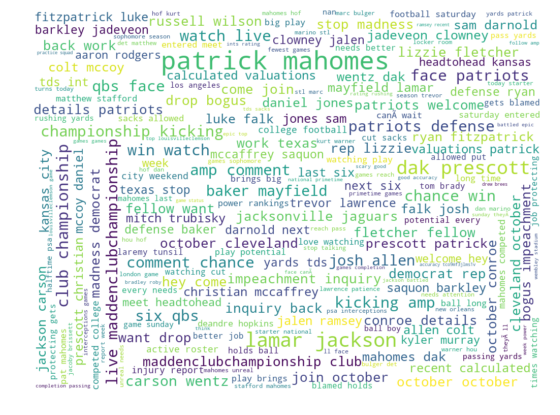

In [18]:
# wordcloud of complete training set - cleaned text
br.wordcloud_draw(train['text_clean'], color='white',max_words=200)

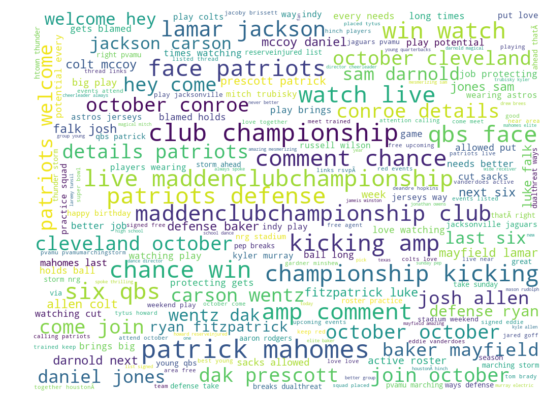

In [19]:
# draw positive word cloud
pos_text = train[train['sentiment']=='positive'].text_clean
# wordcloud of complete training set
br.wordcloud_draw(pos_text, color='white',max_words=200)

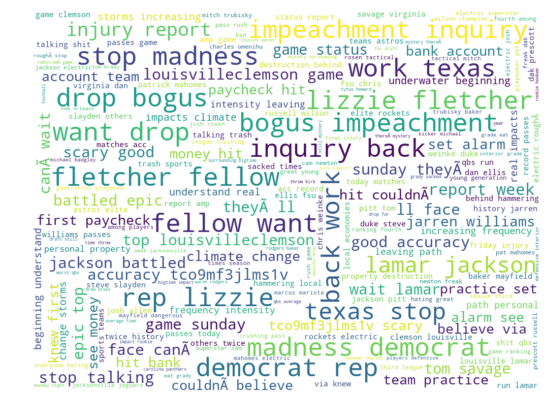

In [20]:
# draw positive word cloud
neg_text = train[train['sentiment']=='negative'].text_clean
# wordcloud of complete training set
br.wordcloud_draw(neg_text, color='white',max_words=200)

In [21]:
# draw positive word cloud
#neg_player_text = train[train['sentiment']=='negative' & train['nfl_type'] == 'player'].text
# wordcloud of complete training set
#br.wordcloud_draw(neg_player_text, color='white',max_words=200)

In [22]:
train['text'].values[:20]

array(['You mean the same fan experts who could see Lamar Jackson and Deshaun Watson would be great?',
       'Deshaun Watson or Sam Darnold?  WhoShouldIStart',
       'RT Top 5 current NFL quarterbacks   1. Tom Brady  2. Lamar Jackson  3. Russel Wilson  4. Patrick Mahomes  5. Deshaun WatsonÃ\x83Â\x83Ã\x82Â¢Ã\x83Â\x82Ã\x82Â\x80Ã\x83Â\x82Ã\x82Â¦',
       'A NFL team I love: Browns A NFL team I like: Panthers A NFL team I dislike: 49ers A NFL team I hate: Steelers A NFLÃ\x83Â\x83Ã\x82Â¢Ã\x83Â\x82Ã\x82Â\x80Ã\x83Â\x82Ã\x82Â¦',
       'Deshaun Watson',
       'NFL Leaders in Total QBR through week 12  1. Lamar Jackson- 82.0 2. Patrick Mahomes- 76.8 3. Russell Wilson- 74.3 4. Dak Prescott- 73.5 5. Deshaun Watson- 70.3 6. Matthew Stafford- 69.0 7. Kyler Murray- 62.9 8. Carson Wentz- 62.8 9. Kirk Cousins- 62.8 10. Drew Brees- 60.0',
       'My top 10 QB right now: (unbiased)   1) Lamar Jackson  2) Russell Wilson  3) Deshaun Watson  4) Patrick Mahomes 5) Aaron Rodgers  6) Kirk Cousins 7) Dak Pr

In [23]:
def clean_features(token_map,lower_case, stop_words, remove_punc, remove_non_alphabetic, stemming, logger=logger):
    
    kf = br.clean_text(logger, token_map,
                     custom_stop_words=[],
                     remove_pun=remove_punc,
                     remove_non_alphabetic=remove_non_alphabetic,
                     remove_stop_words=stop_words,
                     lower_case=lower_case,
                     stemming=stemming,)
    
    return kf

In [24]:
# this block is just to filter out non-utf8 text from the data set. it was causing the Vectorizer classes to fail
train_dict = train[['id','text_clean','sentiment_class']]
text_tokens = []
text_ids = []
text_classes = []

for index, row in train_dict.iterrows():
    try:
        tokens = word_tokenize(row['text_clean'])
        
        text_tokens.append(tokens)
        text_ids.append(row['id'])
        text_classes.append(row['sentiment_class'])
    except BaseException as be:
        logger.warning(f'****WARNING***: Caught Exception Tokenizing text: {be}')



****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing

****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing text: expected string or bytes-like object
****WARNING***: Caught Exception Tokenizing

In [25]:
text_tokens[:10]

[['mean',
  'fan',
  'experts',
  'could',
  'see',
  'lamar',
  'jackson',
  'would',
  'great'],
 ['sam', 'darnold', 'whoshouldistart'],
 ['top',
  'current',
  'quarterbacks',
  'tom',
  'brady',
  'lamar',
  'jackson',
  'russel',
  'wilson',
  'patrick',
  'mahomes',
  'watsonÃ\x83Â£Ã\x82Â¢Ã\x83Â¢Ã\x82Â\x80Ã\x83Â¢Ã\x82Â¦'],
 ['team',
  'love',
  'browns',
  'team',
  'like',
  'panthers',
  'team',
  'dislike',
  'team',
  'hate',
  'steelers',
  'nflÃ\x83Â£Ã\x82Â¢Ã\x83Â¢Ã\x82Â\x80Ã\x83Â¢Ã\x82Â¦'],
 ['leaders',
  'total',
  'qbr',
  'week',
  'lamar',
  'jackson',
  'patrick',
  'mahomes',
  'russell',
  'wilson',
  'dak',
  'prescott',
  'matthew',
  'stafford',
  'kyler',
  'murray',
  'carson',
  'wentz',
  'kirk',
  'cousins',
  'drew',
  'brees'],
 ['top',
  'right',
  'unbiased',
  'lamar',
  'jackson',
  'russell',
  'wilson',
  'patrick',
  'mahomes',
  'aaron',
  'rodgers',
  'kirk',
  'cousins',
  'dak',
  'prescott',
  'drew',
  'brees',
  'matt',
  'ryan',
  'jacoby',


In [26]:
train_clean_df = pd.DataFrame()
text = []
for doc in text_tokens:
    text.append(' '.join(doc))


train_clean_df['id'] = text_ids
train_clean_df['text'] = text
train_clean_df['sentiment_class'] = text_classes
train_clean_df.shape

(9761, 3)

In [27]:
train_clean_df['text'][:5]

0    mean fan experts could see lamar jackson would...
1                          sam darnold whoshouldistart
2    top current quarterbacks tom brady lamar jacks...
3    team love browns team like panthers team disli...
4    leaders total qbr week lamar jackson patrick m...
Name: text, dtype: object

In [28]:
#
X = train_clean_df['text'].values
y = train_clean_df['sentiment_class'].values.astype('int32',copy=False)

#X = train['text_clean'].values
#y = train['sentiment_class'].values.astype('int32',copy=False)
logger.info(f'X shape: {X.shape}')
logger.info(f'y shape: {y.shape}')
logger.info(f'y unique lables: {train.sentiment_class.unique()}')

X shape: (9761,)
y shape: (9761,)
y unique lables: [2 1 0]


## TASK 1:
________________________________________________________________________________________________
Output confusion matrix, precision and recall values for the Sentiment training data.

* Build a unigram MNB model and a unigram SVMs model.
* Print the top 10 indicative words for the most positive category and the most negative category from the MNB and SVMs models respectively. 
* You can change other parameters to your preference. Report your choice and explain why. 
* Report the confusion matrix, precisions, and recalls. Explain whether your models performed equally well on all categories, or some categories turn out to be easier or more difficult for MNB or SVMs. 
* Submit your revised script along with your report.

### Split train/test data for hold-out test
* 60/40 split ratio
* plot training/test label balance
* perform one-hot encoding on dataset labels
* initalize unigram CountVectorizer
* train vector on X_train content

#### Multinomial Naive Bayes Classification (MNB)
Python package scikit-learn v0.21.3 [sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.htm)


Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

In [29]:
token_pattern = r'[a-zA-Z\-][a-zA-Z\-]{2,}'

In [30]:
# Initialize a unigram vector object
t1_mnb_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,max_df=0.95,input='content',stop_words='english', token_pattern=token_pattern)
t1_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,max_df=0.95,input='content',stop_words='english', token_pattern=token_pattern)

In [31]:
# Input parameter configurations
reportPath_task1 = f'{outputDir}/task1_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=1

Model Name:             task1_mnb_cnt_vec_unigram_v1


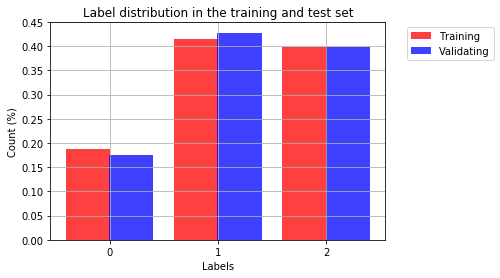

Vectorizer[count], category[task_1], version[1] --> transformed shape: (5856, 3287)
Vectorizer[count], category[task_1], version[1] --> transformed size: 57783
Vectorizer[count], category[task_1], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_1], version[1] --> vocabulary size: 3287
Vector Top 20 Head:
         feature  feature_index
732        zone           3286
1129       zeke           3285
492         yrs           3284
1840    youtube           3283
843       youth           3282
1445    younger           3281
448       young           3280
2098       york           3279
2859       ylem           3278
3061  yesterday           3277
759         yes           3276
2187     yellow           3275
482       years           3274
1509   yearbook           3273
1059       year           3272
1725       yeah           3271
2006        yea           3270
777         yds           3269
324       yards           3268
2820       yarb  

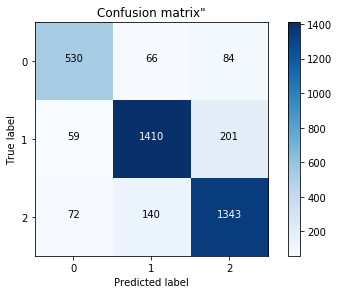

y_test head: [0 1 2 2 0 2 1 2 2 2]
model_pred head: [0 1 2 2 1 2 1 1 2 2]
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       680
     neutral       0.87      0.84      0.86      1670
    positive       0.82      0.86      0.84      1555

   micro avg       0.84      0.84      0.84      3905
   macro avg       0.83      0.83      0.83      3905
weighted avg       0.84      0.84      0.84      3905



In [32]:
# instantiate niave bayes models
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task1_mnb_cnt_vec_unigram_v{v}'

# perform core training and validation steps
mnb_test_pred_results = build_test_validate_models(t1_mnb_count_vec_unigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task1,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

##### Print the top 10 indicative words for the most positive category and the most negative category
Interpret the trained model

##### Linear Support Vector Classification (LinearSVC)
Python package scikit-learn v0.21.3 [sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

**Interpreting LinearSVC models**
* LinearSVC uses a one-vs-all strategy to extend the binary SVM classifier to multi-class problems
* For the Kaggle sentiment classification problem, there are five categories 0,1,2,3,4 with 0 as very negative and 4 very positive
* LinearSVC builds five binary classifier, "very negative vs. others", "negative vs. others", "neutral vs. others", "positive vs. others", "very positive vs. others", and then pick the most confident prediction as the final prediction.
* Linear SVC also ranks all features based on their contribution to distinguish the two concepts in each binary classifier

Model Name:             task1_svm_cnt_vec_unigram_v1


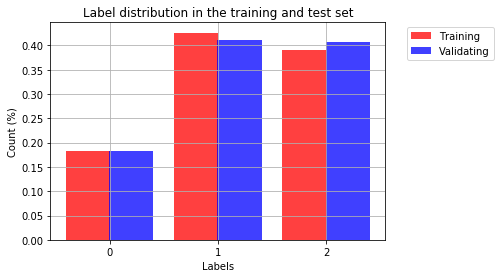

Vectorizer[count], category[task_1], version[1] --> transformed shape: (5856, 3244)
Vectorizer[count], category[task_1], version[1] --> transformed size: 57755
Vectorizer[count], category[task_1], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_1], version[1] --> vocabulary size: 3244
Vector Top 20 Head:
         feature  feature_index
796        zone           3243
1050       zeke           3242
1658    youtube           3241
2522      youth           3240
2143    younger           3239
287       young           3238
1480       york           3237
2040       ylem           3236
1896      yikes           3235
1846  yesterday           3234
367         yes           3233
1987     yellow           3232
378       years           3231
3002   yearbook           3230
889        year           3229
1235       yeah           3228
1616        yea           3227
2226        yds           3226
27        yards           3225
1736     yardas  

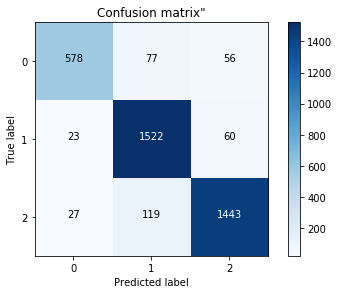

y_test head: [1 2 1 2 2 1 2 2 1 2]
model_pred head: [1 2 1 2 2 1 2 2 1 2]
              precision    recall  f1-score   support

    negative       0.92      0.81      0.86       711
     neutral       0.89      0.95      0.92      1605
    positive       0.93      0.91      0.92      1589

   micro avg       0.91      0.91      0.91      3905
   macro avg       0.91      0.89      0.90      3905
weighted avg       0.91      0.91      0.91      3905



In [33]:
# instantiate the LinearSVC model
svm_clf = LinearSVC(C=1)

model_name = f'task1_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_test_pred_results = build_test_validate_models(t1_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task1,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## TASK 2:
________________________________________________________________________________________________
Consult the sklearn website to learn more about the CountVectorizer. Revise the script to build a MNB model and a SVMs model based on both unigram and bigram. For fair comparison, please keep the same 60% for training and the rest 40% for testing. Also keep your other vectorization parameters the same as in Task 1.

- Compare the confusion matrix and other evaluation measures (accuracy, precision, recall). Discuss whether adding bi-grams was helpful for sentiment classification, based on MNB and SVMs respectively.

In [34]:
# Initialize a unigram vector object
t2_mnb_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english',token_pattern=token_pattern)
t2_mnb_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)

t2_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)
t2_svm_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)

In [35]:
# Input parameter configurations
reportPath_task2 = f'{outputDir}/task2_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=1

Model Name:             task2_mnb_cnt_vec_unigram_v1


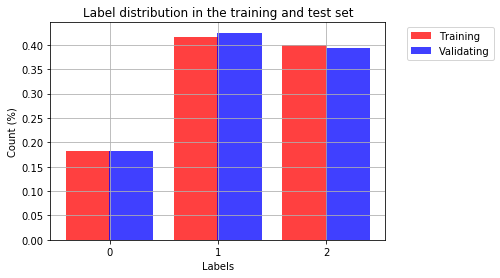

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5856, 3284)
Vectorizer[count], category[task_2], version[1] --> transformed size: 57953
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 3284
Vector Top 20 Head:
         feature  feature_index
2489       zone           3283
375        zeke           3282
2450        yrs           3281
1504      youth           3280
2352    younger           3279
413       young           3278
1671       york           3277
3057       ylem           3276
2017  yesterday           3275
904         yes           3274
2400     yellow           3273
809       years           3272
996        year           3271
626        yeah           3270
876         yea           3269
952         yds           3268
4         yards           3267
2071     yardas           3266
3164       yarb           3265
370     yannick  

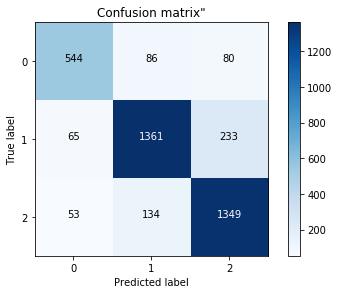

y_test head: [1 1 1 1 0 1 1 0 2 1]
model_pred head: [1 1 1 1 0 2 1 0 2 1]
              precision    recall  f1-score   support

    negative       0.82      0.77      0.79       710
     neutral       0.86      0.82      0.84      1659
    positive       0.81      0.88      0.84      1536

   micro avg       0.83      0.83      0.83      3905
   macro avg       0.83      0.82      0.83      3905
weighted avg       0.83      0.83      0.83      3905



In [36]:
## ----- MNB UNIGRAM ------ ##
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task2_mnb_cnt_vec_unigram_v{v}'

# perform core training and validation steps
mnb_unigram_test_pred_results = build_test_validate_models(t2_mnb_count_vec_unigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_mnb_cnt_vec_bigram_v1


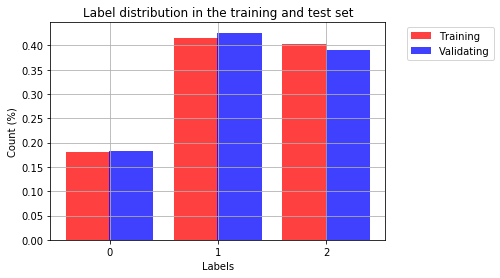

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5856, 8494)
Vectorizer[count], category[task_2], version[1] --> transformed size: 104074
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 8494
Vector Top 20 Head:
                  feature  feature_index
6126           zone read           8493
5476        zone offense           8492
8013      zone coverages           8491
5472                zone           8490
7752                zero           8489
6674        zeke elliott           8488
6670                zeke           8487
4746   youtube rosterguy           8486
4729             youtube           8485
7649          youth navy           8484
3051               youth           8483
2524             younger           8482
8481  young unbelievably           8481
487            young ran           8480
750   young quarterbacks           8

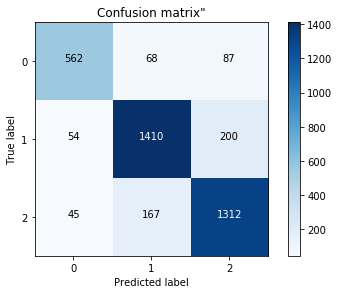

y_test head: [1 2 2 1 0 1 1 1 1 1]
model_pred head: [1 2 2 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

    negative       0.85      0.78      0.82       717
     neutral       0.86      0.85      0.85      1664
    positive       0.82      0.86      0.84      1524

   micro avg       0.84      0.84      0.84      3905
   macro avg       0.84      0.83      0.84      3905
weighted avg       0.84      0.84      0.84      3905



In [37]:
## ----- MNB BIGRAM ------ ##
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task2_mnb_cnt_vec_bigram_v{v}'

# perform core training and validation steps
mnb_bigram_test_pred_results = build_test_validate_models(t2_mnb_count_vec_bigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_svm_cnt_vec_unigram_v1


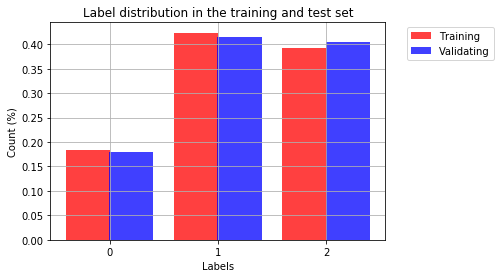

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5856, 3255)
Vectorizer[count], category[task_2], version[1] --> transformed size: 58131
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 3255
Vector Top 20 Head:
         feature  feature_index
2612       zone           3254
2336       zeke           3253
1660    youtube           3252
1498      youth           3251
2524    younger           3250
22        young           3249
1537       york           3248
3148       ylem           3247
2354  yesterday           3246
641         yes           3245
2089     yellow           3244
1119      years           3243
775        year           3242
1351       yeah           3241
1146        yea           3240
2180        yds           3239
424       yards           3238
2852     yardas           3237
798     yannick           3236
1716    yankees  

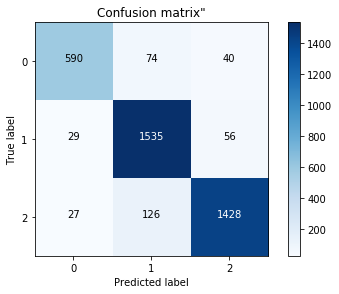

y_test head: [1 1 0 2 2 2 1 2 2 0]
model_pred head: [1 1 0 2 2 2 1 2 2 0]
              precision    recall  f1-score   support

    negative       0.91      0.84      0.87       704
     neutral       0.88      0.95      0.92      1620
    positive       0.94      0.90      0.92      1581

   micro avg       0.91      0.91      0.91      3905
   macro avg       0.91      0.90      0.90      3905
weighted avg       0.91      0.91      0.91      3905



In [38]:
## ----- SVM UNIGRAM ------ ##
svm_clf = LinearSVC(C=1)

model_name = f'task2_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t2_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_svm_cnt_vec_bigram_v1


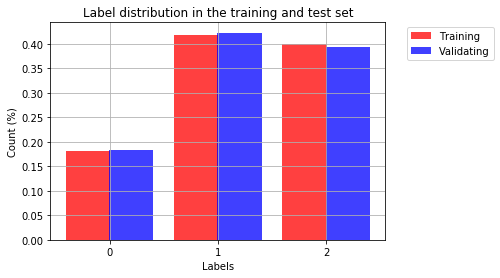

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5856, 8686)
Vectorizer[count], category[task_2], version[1] --> transformed size: 105114
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 8686
Vector Top 20 Head:
                  feature  feature_index
5062           zone read           8685
5852        zone offense           8684
3396                zone           8683
8143        zeke elliott           8682
8139                zeke           8681
5589                 ypg           8680
5308   youtube rosterguy           8679
5296             youtube           8678
1142         youth sizes           8677
1136               youth           8676
7101             younger           8675
1097           young ran           8674
1381  young quarterbacks           8673
2156           young qbs           8672
572           young look           8

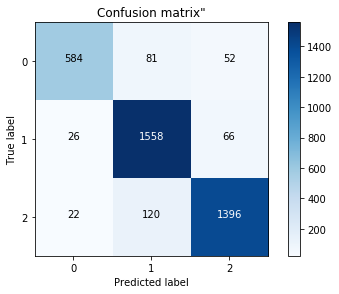

y_test head: [2 2 1 0 0 0 0 0 2 1]
model_pred head: [2 2 1 0 0 0 1 0 2 1]
              precision    recall  f1-score   support

    negative       0.92      0.81      0.87       717
     neutral       0.89      0.94      0.91      1650
    positive       0.92      0.91      0.91      1538

   micro avg       0.91      0.91      0.91      3905
   macro avg       0.91      0.89      0.90      3905
weighted avg       0.91      0.91      0.91      3905



In [39]:
## ----- SVM BIGRAM ------ ##
svm_clf = LinearSVC(C=1)

model_name = f'task2_svm_cnt_vec_bigram_v{v}'

# perform core training and validation steps
svm_bigram_test_pred_results = build_test_validate_models(t2_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## TASK 3:
________________________________________________________________________________________________
Now revise the sample script to build your best SVMs model by tuning parameters and using the entire training data set (changing from 60% to 100%). Report what parameters you used to train the model, and its cross validation accuracy.



In [40]:
# Initialize a unigram vector object
t3_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english',token_pattern=token_pattern)
t3_svm_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)

In [41]:
# using gridsearch to tune SVC hyperparameters
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# one hot encoding for dataset labels
lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train)
y_test = lbe.fit_transform(y_test)

train_vec = br.train_vector(logger, t3_svm_count_vec_unigram, X_train, category=None, v_type='count', version=1)
X_train_vec = train_vec[1]

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'loss': ['hinge','squared_hinge'], 
              }  
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(X_train_vec, y_train) 

Vectorizer[count], category[None], version[1] --> transformed shape: (8784, 3950)
Vectorizer[count], category[None], version[1] --> transformed size: 87470
Vectorizer[count], category[None], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[None], version[1] --> vocabulary size: 3950
Vector Top 20 Head:
         feature  feature_index
1195       zone           3949
2940        zip           3948
3059       zero           3947
1964       zeke           3946
2366        yrs           3945
3700        ypg           3944
2907    youtube           3943
366       youth           3942
3017    younger           3941
393       young           3940
2440       york           3939
3338        ymd           3938
1565       ylem           3937
3923      yikes           3936
3261  yesterday           3935
1316        yes           3934
2977     yellow           3933
432       years           3932
291        year           3931
2180       yeah          

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.1, loss=hinge ...............................................
[CV] ...... C=0.1, loss=hinge, score=0.8822123591669512, total=   0.0s
[CV] C=0.1, loss=hinge ...............................................
[CV] ....... C=0.1, loss=hinge, score=0.880464480874317, total=   0.2s
[CV] C=0.1, loss=hinge ...............................................
[CV] ....... C=0.1, loss=hinge, score=0.896822685343355, total=   0.1s
[CV] C=0.1, loss=squared_hinge .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  C=0.1, loss=squared_hinge, score=0.902697166268351, total=   0.0s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.9030054644808743, total=   0.2s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.912880081995217, total=   0.1s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.9190850119494708, total=   1.0s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.9135928961748634, total=   0.5s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.9180047830543219, total=   0.6s
[CV] C=1, loss=squared_hinge .........................................
[CV]  C=1, loss=squared_hinge, score=0.9180607715944008, total=   0.4s
[CV] C=1, loss=squared_hinge .........................................
[C

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.8s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'loss': ['hinge', 'squared_hinge']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [42]:
# print best parameter after tuning 
logger.info(f'grid.best_params_: {grid.best_params_}') 
  
# print how our model looks after hyper-parameter tuning 
logger.info(f'grid.best_estimator_: {grid.best_estimator_}') 

grid.best_params_: {'C': 1, 'loss': 'hinge'}
grid.best_estimator_: LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [43]:
# Input parameter configurations
reportPath_task3 = f'{outputDir}/task3_models_report.txt'
cv=10
train_test_split_ratio=0.2
n_classes=len(np.unique(y))
v=1

Model Name:             task3_svm_cnt_vec_unigram_v1


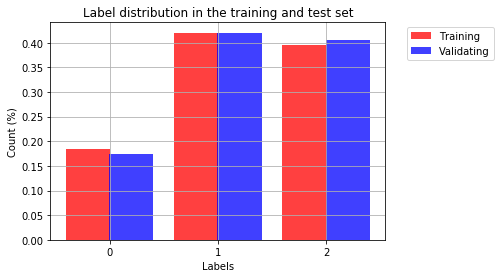

Vectorizer[count], category[task_3], version[1] --> transformed shape: (7808, 3763)
Vectorizer[count], category[task_3], version[1] --> transformed size: 77568
Vectorizer[count], category[task_3], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[1] --> vocabulary size: 3763
Vector Top 20 Head:
         feature  feature_index
247        zone           3762
3644        zip           3761
2353       zero           3760
1768       zeke           3759
3028        ypg           3758
3440    youtube           3757
1131      youth           3756
3089    younger           3755
160       young           3754
1636       york           3753
999         ymd           3752
655        ylem           3751
1026      yikes           3750
1108  yesterday           3749
1203        yes           3748
2782     yellow           3747
381       years           3746
141        year           3745
1758       yeah           3744
2358        yea  

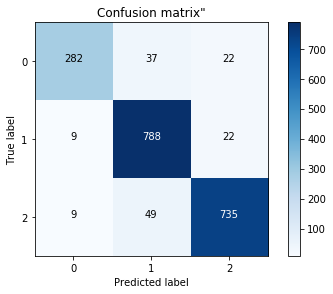

y_test head: [2 1 0 0 2 2 2 2 2 2]
model_pred head: [1 1 0 0 2 2 2 2 2 2]
              precision    recall  f1-score   support

    negative       0.94      0.83      0.88       341
     neutral       0.90      0.96      0.93       819
    positive       0.94      0.93      0.94       793

   micro avg       0.92      0.92      0.92      1953
   macro avg       0.93      0.91      0.92      1953
weighted avg       0.93      0.92      0.92      1953



In [44]:
## ----- SVM UNIGRAM ------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task3_svm_final_cnt_vec_bigram_v1


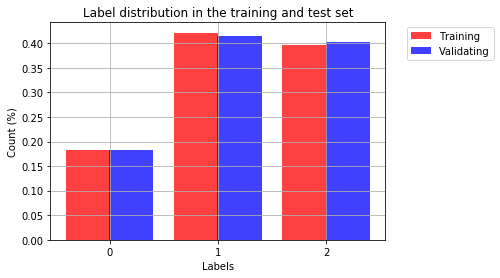

Vectorizer[count], category[task_3], version[1] --> transformed shape: (7808, 10195)
Vectorizer[count], category[task_3], version[1] --> transformed size: 141360
Vectorizer[count], category[task_3], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[1] --> vocabulary size: 10195
Vector Top 20 Head:
                  feature  feature_index
4852           zone read          10194
7892      zone coverages          10193
4847                zone          10192
8395           zeke deal          10191
5581                zeke          10190
5639                 ypg          10189
206    youtube rosterguy          10188
188              youtube          10187
7541   youth underserved          10186
8920         youth sizes          10185
5652          youth navy          10184
2137               youth          10183
7207       younger argue          10182
2959             younger          10181
5246  young unbelievably          

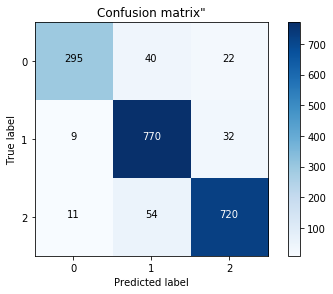

y_test head: [1 1 2 2 1 1 2 2 2 1]
model_pred head: [1 1 1 2 1 1 2 2 2 1]
              precision    recall  f1-score   support

    negative       0.94      0.83      0.88       357
     neutral       0.89      0.95      0.92       811
    positive       0.93      0.92      0.92       785

   micro avg       0.91      0.91      0.91      1953
   macro avg       0.92      0.90      0.91      1953
weighted avg       0.92      0.91      0.91      1953



In [45]:
## ----- SVM BIGRAM ------ ##
svm_clf_final = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_final_cnt_vec_bigram_v{v}'

# perform core training and validation steps
svm_bigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf_final,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

In [ ]:
## ----- SVM Unigram ------ ##
svm_clf_final = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_final_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf_final,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## Task 4 - Create Models from best scorrers in HW6

In [46]:
# Initialize a unigram vector object
t4_svm_tfidf_vec_unigram_bool = br.inst_vectorizer('unigram','tfidf',min_df=2,input='content',stop_words='english', binary=True, token_pattern=token_pattern)
t4_svm_tfidf_vec_bigram_bool = br.inst_vectorizer('bigram','tfidf',min_df=2,input='content',stop_words='english', binary=True, token_pattern=token_pattern)

In [47]:
# Input parameter configurations
reportPath_task4 = f'{outputDir}/task4_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=1

Model Name:             task4_svm_tfidf_vec_unigram_bool_v1


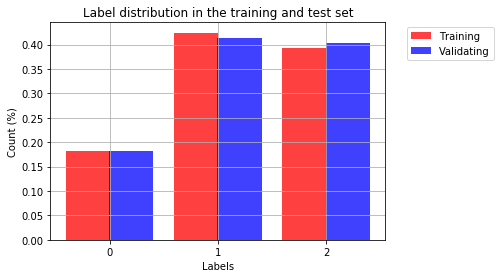

Vectorizer[tfidf], category[task_4], version[1] --> transformed shape: (5856, 3286)
Vectorizer[tfidf], category[task_4], version[1] --> transformed size: 57841
Vectorizer[tfidf], category[task_4], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[task_4], version[1] --> vocabulary size: 3286
Vector Top 20 Head:
         feature  feature_index
1094       zone           3285
2060        zip           3284
971        zeke           3283
1826        ypg           3282
649       youth           3281
2152    younger           3280
461       young           3279
2296       york           3278
2549       ylem           3277
1898      yikes           3276
916   yesterday           3275
538         yes           3274
3049     yellow           3273
604       years           3272
3081   yearbook           3271
5          year           3270
1490       yeah           3269
2741        yea           3268
1042        yds           3267
108       yards  

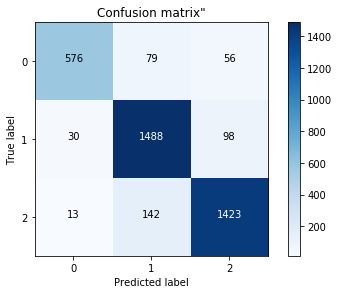

y_test head: [2 0 0 2 1 1 2 2 2 2]
model_pred head: [2 0 0 1 1 1 2 2 2 2]
              precision    recall  f1-score   support

    negative       0.93      0.81      0.87       711
     neutral       0.87      0.92      0.90      1616
    positive       0.90      0.90      0.90      1578

   micro avg       0.89      0.89      0.89      3905
   macro avg       0.90      0.88      0.89      3905
weighted avg       0.89      0.89      0.89      3905



In [48]:
## ----- SVM UNIGRAM BOOL------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task4_svm_tfidf_vec_unigram_bool_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t4_svm_tfidf_vec_unigram_bool,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task4,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task4_svm_tfidf_vec_bigram_bool_v1


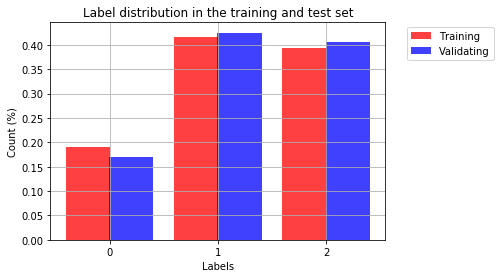

Vectorizer[tfidf], category[task_4], version[1] --> transformed shape: (5856, 8574)
Vectorizer[tfidf], category[task_4], version[1] --> transformed size: 105640
Vectorizer[tfidf], category[task_4], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[task_4], version[1] --> vocabulary size: 8574
Vector Top 20 Head:
                  feature  feature_index
5602        zone offense           8573
5599                zone           8572
6768                 zip           8571
3694                zero           8570
1723                zeke           8569
8462             yrs old           8568
8457                 yrs           8567
5710   youtube rosterguy           8566
5699             youtube           8565
957    youth underserved           8564
6460         youth sizes           8563
8338          youth navy           8562
939                youth           8561
4481             younger           8560
4666  young unbelievably           8

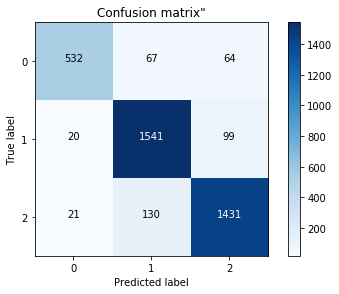

y_test head: [2 2 1 0 0 2 1 2 2 2]
model_pred head: [2 2 1 2 0 2 1 2 1 2]
              precision    recall  f1-score   support

    negative       0.93      0.80      0.86       663
     neutral       0.89      0.93      0.91      1660
    positive       0.90      0.90      0.90      1582

   micro avg       0.90      0.90      0.90      3905
   macro avg       0.90      0.88      0.89      3905
weighted avg       0.90      0.90      0.90      3905



In [49]:
## ----- SVM BIGRAM BOOL------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task4_svm_tfidf_vec_bigram_bool_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t4_svm_tfidf_vec_bigram_bool,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task4,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

### Evaluate Model Results

In [50]:
# build summary report df
summary_report_df = pd.DataFrame()

summary_report_df['Model_Type'] = model_types
summary_report_df['Category'] = categories
summary_report_df['Vectorizer'] = vectorizers
summary_report_df['N_Gram'] = ngrams
summary_report_df['Experiment_Model_Name'] = exp_model_names
summary_report_df['Dataset_Version'] = dataset_versions
summary_report_df['Cross_Folds'] = cross_folds
summary_report_df['Prediction_Accuracy'] = prediction_accuracys
summary_report_df['Total_Prediction_Points'] = total_prediction_points
summary_report_df['Test_Recall_Score_Avg'] = test_recall_score_avgs
summary_report_df['Test_Precision_Score_Avg'] = test_precision_score_avgs
summary_report_df['Train_Recall_Score_Avg'] = train_recall_score_avgs
summary_report_df['Train_Precision_Score_Avg'] = train_precision_score_avgs
summary_report_df['Total_Build_Time'] = total_build_times
summary_report_df['Total_Predict_Time'] = total_predict_time
summary_report_df['Confusion_Matrix'] = confusion_matrixs

summary_report_df.head(10)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,84.07,3905,0.8220,0.8274,0.8821,0.8866,0.1242,0.0024,[[ 530 66 84]\n [ 59 1410 201]\n [ 72 ...
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,90.73,3905,0.9003,0.9189,0.9954,0.9972,5.5715,0.0008,[[ 578 77 56]\n [ 23 1522 60]\n [ 27 ...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,83.33,3905,0.8226,0.8262,0.8860,0.8919,0.0947,0.0011,[[ 544 86 80]\n [ 65 1361 233]\n [ 53 ...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,84.10,3905,0.8443,0.8478,0.9047,0.9099,0.1792,0.0015,[[ 562 68 87]\n [ 54 1410 200]\n [ 45 ...
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,90.99,3905,0.8963,0.9165,0.9951,0.9967,7.3672,0.0014,[[ 590 74 40]\n [ 29 1535 56]\n [ 27 ...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,90.60,3905,0.8956,0.9141,0.9969,0.9979,9.7347,0.0020,[[ 584 81 52]\n [ 26 1558 66]\n [ 22 ...
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,92.42,1953,0.9133,0.9312,0.9877,0.9923,7.9983,0.0010,[[282 37 22]\n [ 9 788 22]\n [ 9 49 735]]
7,LinearSVM,task_3,count,bigram,task3_svm_final_cnt_vec_bigram_v1,v1,10,91.40,1953,0.9050,0.9218,0.9932,0.9960,7.3890,0.0017,[[295 40 22]\n [ 9 770 32]\n [ 11 54 720]]
8,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,89.30,3905,0.8755,0.9043,0.9588,0.9733,5.4828,0.0014,[[ 576 79 56]\n [ 30 1488 98]\n [ 13 ...
9,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v1,v1,10,89.73,3905,0.8853,0.9138,0.9697,0.9795,5.1260,0.0022,[[ 532 67 64]\n [ 20 1541 99]\n [ 21 ...


In [51]:
sorted_summary_report = summary_report_df.sort_values(by=['Prediction_Accuracy','Experiment_Model_Name'], ascending=False)
sorted_summary_report

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,92.42,1953,0.9133,0.9312,0.9877,0.9923,7.9983,0.0010,[[282 37 22]\n [ 9 788 22]\n [ 9 49 735]]
7,LinearSVM,task_3,count,bigram,task3_svm_final_cnt_vec_bigram_v1,v1,10,91.40,1953,0.9050,0.9218,0.9932,0.9960,7.3890,0.0017,[[295 40 22]\n [ 9 770 32]\n [ 11 54 720]]
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,90.99,3905,0.8963,0.9165,0.9951,0.9967,7.3672,0.0014,[[ 590 74 40]\n [ 29 1535 56]\n [ 27 ...
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,90.73,3905,0.9003,0.9189,0.9954,0.9972,5.5715,0.0008,[[ 578 77 56]\n [ 23 1522 60]\n [ 27 ...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,90.60,3905,0.8956,0.9141,0.9969,0.9979,9.7347,0.0020,[[ 584 81 52]\n [ 26 1558 66]\n [ 22 ...
9,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v1,v1,10,89.73,3905,0.8853,0.9138,0.9697,0.9795,5.1260,0.0022,[[ 532 67 64]\n [ 20 1541 99]\n [ 21 ...
8,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,89.30,3905,0.8755,0.9043,0.9588,0.9733,5.4828,0.0014,[[ 576 79 56]\n [ 30 1488 98]\n [ 13 ...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,84.10,3905,0.8443,0.8478,0.9047,0.9099,0.1792,0.0015,[[ 562 68 87]\n [ 54 1410 200]\n [ 45 ...
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,84.07,3905,0.8220,0.8274,0.8821,0.8866,0.1242,0.0024,[[ 530 66 84]\n [ 59 1410 201]\n [ 72 ...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,83.33,3905,0.8226,0.8262,0.8860,0.8919,0.0947,0.0011,[[ 544 86 80]\n [ 65 1361 233]\n [ 53 ...


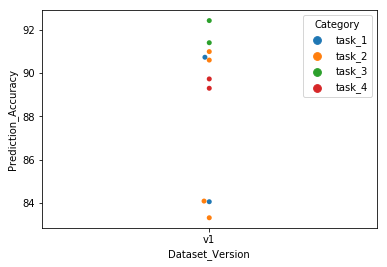

In [52]:
sns.swarmplot(x='Dataset_Version',y='Prediction_Accuracy',hue='Category',data=summary_report_df)

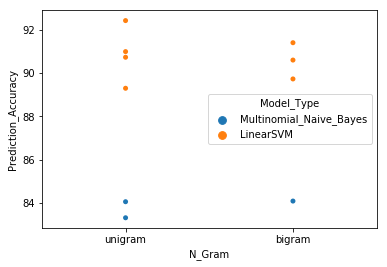

In [53]:
sns.swarmplot(x='N_Gram',y='Prediction_Accuracy',hue='Model_Type',data=summary_report_df)

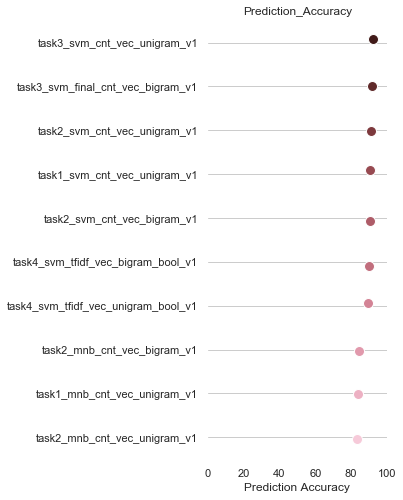

In [54]:
sns.set(style="whitegrid")
g = sns.PairGrid(sorted_summary_report,x_vars='Prediction_Accuracy', 
                 y_vars=['Experiment_Model_Name'], height=7, aspect=.50)

#Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 100), xlabel="Prediction Accuracy", ylabel="")


# Use semantically meaningful titles for the columns
titles = ["Prediction_Accuracy"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [55]:
sorted_summary_report_v1 = summary_report_df.sort_values(by=['Dataset_Version','Prediction_Accuracy'], ascending=False)
sorted_summary_report_v1.head(10)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,92.42,1953,0.9133,0.9312,0.9877,0.9923,7.9983,0.0010,[[282 37 22]\n [ 9 788 22]\n [ 9 49 735]]
7,LinearSVM,task_3,count,bigram,task3_svm_final_cnt_vec_bigram_v1,v1,10,91.40,1953,0.9050,0.9218,0.9932,0.9960,7.3890,0.0017,[[295 40 22]\n [ 9 770 32]\n [ 11 54 720]]
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,90.99,3905,0.8963,0.9165,0.9951,0.9967,7.3672,0.0014,[[ 590 74 40]\n [ 29 1535 56]\n [ 27 ...
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,90.73,3905,0.9003,0.9189,0.9954,0.9972,5.5715,0.0008,[[ 578 77 56]\n [ 23 1522 60]\n [ 27 ...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,90.60,3905,0.8956,0.9141,0.9969,0.9979,9.7347,0.0020,[[ 584 81 52]\n [ 26 1558 66]\n [ 22 ...
9,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v1,v1,10,89.73,3905,0.8853,0.9138,0.9697,0.9795,5.1260,0.0022,[[ 532 67 64]\n [ 20 1541 99]\n [ 21 ...
8,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,89.30,3905,0.8755,0.9043,0.9588,0.9733,5.4828,0.0014,[[ 576 79 56]\n [ 30 1488 98]\n [ 13 ...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,84.10,3905,0.8443,0.8478,0.9047,0.9099,0.1792,0.0015,[[ 562 68 87]\n [ 54 1410 200]\n [ 45 ...
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,84.07,3905,0.8220,0.8274,0.8821,0.8866,0.1242,0.0024,[[ 530 66 84]\n [ 59 1410 201]\n [ 72 ...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,83.33,3905,0.8226,0.8262,0.8860,0.8919,0.0947,0.0011,[[ 544 86 80]\n [ 65 1361 233]\n [ 53 ...


In [56]:
# avg prediciton by data version
v4_avg = summary_report_df[summary_report_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = summary_report_df[summary_report_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = summary_report_df[summary_report_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = summary_report_df[summary_report_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = summary_report_df[summary_report_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = summary_report_df[summary_report_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')



V4 Avg Prediciton Accuracy: nan
V3 Avg Prediciton Accuracy: nan
V2 Avg Prediciton Accuracy: nan
V1 Avg Prediciton Accuracy: 88.667
unigram_avg Prediciton Accuracy: 88.47333333333334
bigram_avg Prediciton Accuracy: 88.95750000000001


In [57]:
mnb_df = summary_report_df[summary_report_df['Model_Type']=='Multinomial_Naive_Bayes']
mnb_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,84.10,3905,0.8443,0.8478,0.9047,0.9099,0.1792,0.0015,[[ 562 68 87]\n [ 54 1410 200]\n [ 45 ...
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,84.07,3905,0.8220,0.8274,0.8821,0.8866,0.1242,0.0024,[[ 530 66 84]\n [ 59 1410 201]\n [ 72 ...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,83.33,3905,0.8226,0.8262,0.8860,0.8919,0.0947,0.0011,[[ 544 86 80]\n [ 65 1361 233]\n [ 53 ...


In [58]:
# save summary report
save_as = f'{outputDir}/summary_report.csv'
summary_report_df.to_csv(save_as,index=False)

## Model Timeseries On NFL Only Data
Perform model prediction

# Report Generation
Execute the below cell to create an HTML report

In [59]:
# for report auto generation
# testing markup report generation
#from nbconvert import HTMLExporter
#import codecs
#import os
#import datetime

#stamp = datetime.date.today().strftime("%m-%d-%Y")
#exporter = HTMLExporter(template_file='report.tpl')
#output, resources = exporter.from_filename(notebook_file_name)
#new_fnw = report_file_name
#codecs.open(new_fnw, 'w',encoding='utf-8').write(output)